# Network dynamics of Network FKPP + Atrophy

In the following notebook, I will attempt to simulate data of brain atrophy that is coupled with a reaction-diffusion process of at toxic protein. If successful, I will then build a probablistic model of this using `Turing` to perform Bayesian inference on simulated data.

The model is as follows: 

$\frac{d\mathbf{p}_i}{dt} = -k \sum\limits_{j=1}^{N}\mathbf{L}_{ij}^{\omega}\mathbf{p}_j + \alpha \mathbf{p}_i\left(1-\mathbf{p}_i\right)$

$\frac{d\mathbf{q}_i}{dt} = \beta p_i (1 - q_i)$ 

Where the first equation describes the reaction-diffusion process of prion protein $\mathbf{p}$ and the second equation describes the regional atrophy at a given node $q_i$. 


# Environment

Make sure you are using the correct environment and document the packages used.

In [1]:
using Pkg

In [2]:
Pkg.status()

Status `~/Projects/NetworkTopology/Project.toml`
  [b5ca4192] AdvancedVI v0.1.1
  [76274a88] Bijectors v0.8.14
  [336ed68f] CSV v0.8.4
  [b0b7db55] ComponentArrays v0.8.22
  [a93c6f00] DataFrames v0.22.5
  [2b5f629d] DiffEqBase v6.57.5 `https://github.com/SciML/DiffEqBase.jl.git#sensitivity_interpolation`
  [0c46a032] DifferentialEquations v6.16.0
  [31c24e10] Distributions v0.24.15
  [ced4e74d] DistributionsAD v0.6.20
  [f6369f11] ForwardDiff v0.10.16
  [7073ff75] IJulia v1.23.2
  [093fc24a] LightGraphs v1.3.5
  [c7f686f2] MCMCChains v4.7.0
  [1dea7af3] OrdinaryDiffEq v5.51.2
  [91a5bcdd] Plots v1.6.12
  [c3e4b0f8] Pluto v0.12.21
  [7f904dfe] PlutoUI v0.7.1
  [37e2e3b7] ReverseDiff v1.7.0
  [47aef6b3] SimpleWeightedGraphs v1.1.1
  [f3b207a7] StatsPlots v0.14.19
  [fce5fe82] Turing v0.15.11


In [3]:
using OrdinaryDiffEq, LightGraphs, SimpleWeightedGraphs, Plots, Random, Turing, Base.Threads

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278


In [4]:
Random.seed!(1);

In [7]:
gr()

Plots.GRBackend()

# Model definition 

Firstly, since these are network models, we will first construct a network for the models to exist on. For this, we will use a fully connected weighted graph with 10 nodes.

In [5]:
G = erdos_renyi(10, 0.5)
GW = SimpleWeightedGraph(G)
for e in edges(GW)
    add_edge!(GW, src(e), dst(e), rand())
end

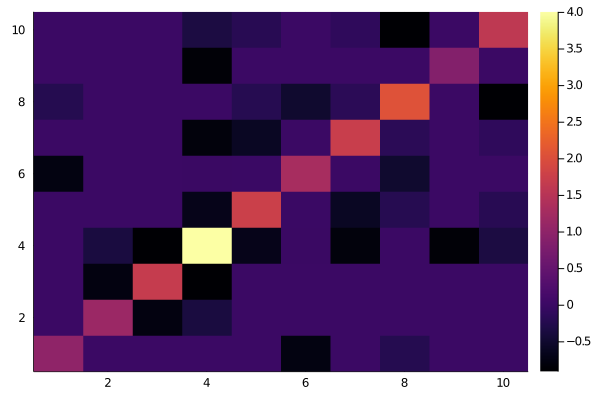

In [8]:
L = laplacian_matrix(GW) 
heatmap(Matrix(L))

## Model Definition 

As stated above, we will implement a network FKPP model for the propogation of toxic protein species that is coupled with a simple atrophy model describing regional atrophy rate given protein concentration.

In [9]:
function NetworkAtrophy(du, u, p, t; L=L)
    n = Int(length(u0)/2)

    x = u[1:n]
    y = u[n+1:2n]

    ρ, α, β = p

    du[1:n] .= -ρ * L * x .+ α .* x .* (1 .- x)
    du[n+1:2n] .= β * x .* (1.0 .- y)
end

NetworkAtrophy (generic function with 1 method)

In [12]:
p = [0.1, 2.0, 1.0]

protein = zeros(10) 
protein[rand(1:10)] = 0.1

u0 = [protein; zeros(10)]
t_span = (0.0,10.0)
prob = ODEProblem(NetworkAtrophy, u0, t_span, p)

sol = solve(prob, Tsit5(), saveat=0.1);

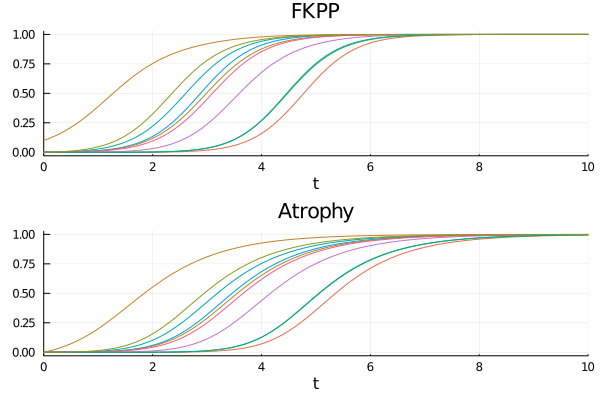

In [24]:
fkpp = plot(sol, vars=(1:10), title="FKPP", legend=false)
atrophy = plot(sol, vars=(11:20), title="Atrophy", legend=false)

plot(fkpp, atrophy, layout=(2,1))


## Inference

In [25]:
@model function NetworkAtrophy(data, problem)
    σ ~ InverseGamma(2, 3)
    r ~ truncated(Normal(0, 1), 0, Inf)
    a ~ truncated(Normal(0, 2), 0, Inf)
    b ~ truncated(Normal(0, 2), 0, Inf)

    u ~ filldist(truncated(Normal(0, 0.1), 0, 1), 20)

    p = [r, a, b]

    prob = remake(problem, u0=u, p=p)
    
    predicted = solve(prob, Tsit5(), saveat=0.1)
    @threads for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end

    return r, a, b, u
end

NetworkAtrophy (generic function with 2 methods)

In [28]:
data = Array(sol);

In [29]:
prior_chain = sample(NetworkAtrophy(data,prob), Prior(), 10_000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (10000×25×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = a, b, r, u[1], u[2], u[3], u[4], u[5], u[6], u[7], u[8], u[9], u[10], u[11], u[12], u[13], u[14], u[15], u[16], u[17], u[18], u[19], u[20], σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

           a    1.6013    1.2168     0.0122    0.0122    9651.3408    0.9999
           b    1.5945    1.2180     0.0122    0.0127    9613.9077    1.0000
           r    0.8017    0.6027     0.0060    0.0061   10263.3647    0.9999
        u[1]    0.0798    0.0598     0.0006    0.0006    8764.4106    1.0000
        u[2]    0.0804    0.0604     0.0006    0.0006    9602.8203    1.0001
        u[3]    0.0791    0.0592     0.0006    0.0006    9597.9427    0.9999
        u[4]    0.0792    0.

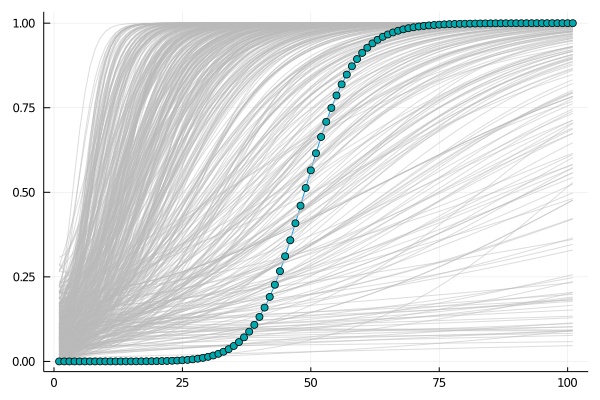

In [30]:
prior_chain_array = Array(prior_chain)

plot(Array(sol)[2,:], w=1, legend = false)
for k in 1:500
    par = prior_chain_array[rand(1:10_000), 1:23]
    resol = solve(remake(prob,u0=par[4:23], p=[par[3],par[1],par[2]]),AutoTsit5(Rosenbrock23()),saveat=0.1)
    plot!(Array(resol)[2,:], alpha=0.5, color = "#BBBBBB", legend = false)
end
scatter!(data[2,:], legend = false)

In [ ]:
model = NetworkAtrophy(data,prob)